In [1]:
%matplotlib inline

from itertools import product

import numpy as np
import prody as pr
from prody.measure.measure import calcPhi, calcPsi

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from difflib import SequenceMatcher

### Definitions and Functions

In [2]:
three_to_one = {
    'ALA': 'A', 'ARG': 'R', 'ASN': 'N', 'ASP': 'D', 'CYS': 'C',
    'GLN': 'Q', 'GLU': 'E', 'GLY': 'G', 'HIS': 'H', 'ILE': 'I',
    'LEU': 'L', 'LYS': 'K', 'MET': 'M', 'PHE': 'F', 'PRO': 'P',
    'SER': 'S', 'THR': 'T', 'TRP': 'W', 'TYR': 'Y', 'VAL': 'V'
}

In [3]:
def kabsch(X, Y, w=None):
    """Rotate and translate X into Y to minimize the MSD between the two.
       
       Implements the SVD method by Kabsch et al. (Acta Crystallogr. 1976, 
       A32, 922).

    Parameters
    ----------
    X : np.array [M x N x 3]
        Array of M sets of mobile coordinates (N x 3) to be transformed by a 
        proper rotation to minimize mean squared displacement (MSD) from Y.
    Y : np.array [M x N x 3]
        Array of M sets of stationary coordinates relative to which to 
        transform X.
    W : np.array [N], optional
        Vector of weights for fitting.

    Returns
    -------
    R : np.array [M x 3 x 3]
        Proper rotation matrices required to transform each set of coordinates 
        in X such that its MSD with the corresponding coordinates in Y is 
        minimized.
    t : np.array [M x 3]
        Translation matrix required to transform X such that its MSD with Y 
        is minimized.
    msd : np.array [M]
        Mean squared displacement after alignment for each pair of coordinates.
    """
    N = X.shape[1]
    if w is None:
        w = np.ones((1, N, 1)) / N
    else:
        w = w.reshape((1, -1, 1)) / w.sum()
    # compute R using the Kabsch algorithm
    Xbar, Ybar = np.sum(X * w, axis=1, keepdims=True), \
                 np.sum(Y * w, axis=1, keepdims=True)
    # subtract Xbar and Ybar, then weight the resulting matrices
    Xc, Yc = np.sqrt(w) * (X - Xbar), np.sqrt(w) * (Y - Ybar)
    H = np.matmul(np.transpose(Xc, (0, 2, 1)), Yc)
    U, S, Vt = np.linalg.svd(H)
    d = np.sign(np.linalg.det(np.matmul(U, Vt)))
    D = np.zeros((X.shape[0], 3, 3))
    D[:, 0, 0] = 1.
    D[:, 1, 1] = 1.
    D[:, 2, 2] = d
    R = np.matmul(U, np.matmul(D, Vt))
    t = (Ybar - np.matmul(Xbar, R)).reshape((-1, 3))
    # compute MSD from aligned coordinates XR
    XRmY = np.matmul(Xc, R) - Yc
    msd = np.sum(XRmY ** 2, axis=(1, 2))
    return R, t, msd

In [372]:
def needleman_wunsch(x, y, match=1, mismatch=1, gap=1):
    """Needleman-Wunsch global alignment algorithm.

    Parameters
    ----------
    x : str
        First string to be aligned.
    y : str
        Second string to be aligned.
    match : int, optional
        Score for a match.
    mismatch : int, optional
        Score for a mismatch.
    gap : int, optional
        Score for a gap.

    Returns
    -------
    z : str
        Optimal alignment of x and y.
    idxs_x = np.array
        Indices of x in the optimal alignment.
    idxs_y = np.array
        Indices of y in the optimal alignment.
    """
    nx = len(x)
    ny = len(y)
    # Optimal score at each possible pair of characters.
    F = np.zeros((nx + 1, ny + 1))
    F[:,0] = np.linspace(0, -nx * gap, nx + 1)
    F[0,:] = np.linspace(0, -ny * gap, ny + 1)
    # Pointers to trace through an optimal aligment.
    P = np.zeros((nx + 1, ny + 1))
    P[:,0] = 3
    P[0,:] = 4
    # Temporary scores.
    t = np.zeros(3)
    for i in range(nx):
        for j in range(ny):
            if x[i] == y[j]:
                t[0] = F[i,j] + match
            else:
                t[0] = F[i,j] - mismatch
            t[1] = F[i,j+1] - gap
            t[2] = F[i+1,j] - gap
            tmax = np.max(t)
            F[i+1,j+1] = tmax
            if t[0] == tmax:
                P[i+1,j+1] += 2
            if t[1] == tmax:
                P[i+1,j+1] += 3
            if t[2] == tmax:
                P[i+1,j+1] += 4
    # Trace through an optimal alignment.
    i = nx
    j = ny
    rx = []
    ry = []
    while i > 0 or j > 0:
        if P[i,j] in [2, 5, 6, 9]:
            rx.append(x[i-1])
            ry.append(y[j-1])
            i -= 1
            j -= 1
        elif P[i,j] in [3, 5, 7, 9]:
            rx.append(x[i-1])
            ry.append('-')
            i -= 1
        elif P[i,j] in [4, 6, 7, 9]:
            rx.append('-')
            ry.append(y[j-1])
            j -= 1
    # Reverse the strings.
    rx = ''.join(rx)[::-1]
    ry = ''.join(ry)[::-1]
    z = '\n'.join([rx, ry])
    idxs_x, idxs_y = [], []
    counter_x, counter_y = 0, 0
    for i in range(len(rx)):
        if rx[i] != '-' and ry[i] != '-':
            idxs_x.append(counter_x)
            idxs_y.append(counter_y)
        if rx[i] != '-':
            counter_x += 1
        if ry[i] != '-':
            counter_y += 1
    idxs_x = np.array(idxs_x)
    idxs_y = np.array(idxs_y)
    return z, idxs_x, idxs_y

In [354]:
def extract_corresponding_coords(pdb1, pdb2, return_phi_psi=False):
    """Given two PDB files, extract the coorresponding backbone coordinates.
    
    Parameters
    ----------
    pdb1 : str
        Path to the first PDB file.
    pdb2 : str
        Path to the second PDB file.
    return_phi_psi : bool, optional
        If True, return the phi and psi angles of the extracted coordinates.

    Returns
    -------
    coords1 : np.array [N x 3]
        Extracted coordinates of the backbone atoms in the first PDB file that 
        have a direct correspondence with the extracted backbone coordinates 
        from the second PDB file.
    coords2 : np.array [N x 3]
        Extracted coordinates of the backbone atoms in the second PDB file that 
        have a direct correspondence with the extracted backbone coordinates 
        from the first PDB file.
    chid1 : str
        Chain ID of the extracted residues from the first PDB file.
    chid2 : str
        Chain ID of the extracted residues from the second PDB file.
    resnums1 : np.array [N]
        Residue numbers of the extracted residues from the first PDB file.
    resnums2 : np.array [N]
        Residue numbers of the extracted residues from the second PDB file.
    phis1 : np.array [N], optional
        Phi angles of the extracted residues from the first PDB file.
    psis1 : np.array [N], optional
        Psi angles of the extracted residues from the first PDB file.
    phis2 : np.array [N], optional
        Phi angles of the extracted residues from the second PDB file.
    psis2 : np.array [N], optional
        Psi angles of the extracted residues from the second PDB file.
    """
    # load PDB files
    mol1 = pr.parsePDB(pdb1).select('protein and name N CA C O')
    mol2 = pr.parsePDB(pdb2).select('protein and name N CA C O')
    # align chains
    chids1 = np.unique(mol1.getChids())
    chids2 = np.unique(mol2.getChids())
    max_alignment = 0
    for chid1, chid2 in product(chids1, chids2):
        _chain1 = mol1.select('chain {}'.format(chid1))
        _chain2 = mol2.select('chain {}'.format(chid2))
        # extract sequences
        seq1 = ''.join([three_to_one[resname] for resname in 
                        _chain1.select('name CA').getResnames()])
        seq2 = ''.join([three_to_one[resname] for resname in 
                        _chain2.select('name CA').getResnames()])
        # find maximum common subsequence
        alignment, _idxs_1, _idxs_2 = needleman_wunsch(seq1, seq2)
        len_alignment = len(_idxs_1)
        if len_alignment > max_alignment:
            max_alignment = len_alignment
            idxs_1 = _idxs_1
            idxs_2 = _idxs_2
            chain1 = _chain1
            chain2 = _chain2
    if max_alignment == 0:
        raise ValueError('No common subsequence found between the two chains')
    chid1 = chain1.getChids()[0]
    chid2 = chain2.getChids()[0]
    # extract corresponding coordinates
    selstr1 = ' or '.join(['resindex {}'.format(i) for i in idxs_1])
    selstr2 = ' or '.join(['resindex {}'.format(i) for i in idxs_2])
    sel1 = chain1.select(selstr1)
    sel2 = chain2.select(selstr2)
    resnums1 = sel1.select('name CA').getResnums()
    resnums2 = sel2.select('name CA').getResnums()
    coords1 = sel1.getCoords()
    coords2 = sel2.getCoords()
    assert len(coords1) == len(coords2)
    if return_phi_psi:
        # extract phi and psi angles
        phis1, psis1, phis2, psis2 = [], [], [], []
        for res in sel1.toAtomGroup().iterResidues():
            try:
                phis1.append(calcPhi(res))
            except:
                phis1.append(np.nan)
            try:
                psis1.append(calcPsi(res))
            except:
                psis1.append(np.nan)
        for res in sel2.toAtomGroup().iterResidues():
            try:
                phis2.append(calcPhi(res))
            except:
                phis2.append(np.nan)
            try:
                psis2.append(calcPsi(res))
            except:
                psis2.append(np.nan)
        phis1, psis1 = np.array(phis1), np.array(psis1)
        phis2, psis2 = np.array(phis2), np.array(psis2)
        return coords1, coords2, chid1, chid2, resnums1, resnums2, \
               phis1, psis1, phis2, psis2
    else:
        return coords1, coords2, chid1, chid2, resnums1, resnums2

In [332]:
def align_windows(coords1, coords2, window_length=5):
    """Align windows of coordinates to minimize the mean squared displacement.
    
    Parameters
    ----------
    coords1 : np.array [N x 3]
        Coordinates of the first set of atoms to be aligned.
    coords2 : np.array [N x 3]
        Coordinates of the second set of atoms to be aligned.
    window_length : int, optional
        Length of the window of residues to be aligned.

    Returns
    -------
    R : np.array [M x 3 x 3]
        Proper rotation matrices required to transform each window of 
        coordinates in coords1 such that its MSD with the corresponding 
        window of coordinates in coords2 is minimized.
    t : np.array [M x 3]
        Translation matrix required to transform each window of coords1 
        such that its MSD with the corresponding window of coords2 is 
        minimized.
    msd : np.array [M]
        Mean squared displacement after alignment for each pair of windows.
    """
    idxs = np.tile(np.arange(window_length * 4), 
                   (coords1.shape[0] // 4 - window_length + 1, 1))
    idxs += 4 * np.arange(coords1.shape[0] // 4 - 
                          window_length + 1).reshape(-1, 1)
    windows1 = coords1[idxs]
    windows2 = coords2[idxs]
    R, t, msd = kabsch(windows1, windows2)
    return R, t, msd

In [333]:
def phi_psi_cosine_difference(phis1, psis1, phis2, psis2):
    """Calculate the cosine differences the corresponding phi and psi angles.
    
    Parameters
    ----------
    phis1 : np.array [N]
        Phi angles of the first set of residues.
    psis1 : np.array [N]
        Psi angles of the first set of residues.
    phis2 : np.array [N]
        Phi angles of the second set of residues.
    psis2 : np.array [N]
        Psi angles of the second set of residues.

    Returns
    -------
    cosine_differences : np.array [N]
        Cosine differences between the corresponding phi and psi angles.
    """
    cosine_differences = np.cos(phis1 - phis2) + np.cos(psis1 - psis2)
    return cosine_differences

In [388]:
def plot_window_rmsds_3d(coords1, coords2, chid1, chid2, 
                         resnums1, resnums2, log=False):
    """Plot the RMSDs of windows of coordinates in 3D.
    
    Parameters
    ----------
    coords1 : np.array [4 * N x 3]
        Coordinates of the first set of atoms to be aligned.
    coords2 : np.array [4 * N x 3]
        Coordinates of the second set of atoms to be aligned.
    chid1 : str
        Chain ID of the first set of residues.
    chid2 : str
        Chain ID of the second set of residues.
    resnums1 : np.array [N]
        Residue numbers of the first set of residues.
    resnums2 : np.array [N]
        Residue numbers of the second set of residues.
    log : bool, optional
        If True, plot the RMSDs in log scale.

    Returns
    -------
    avg_rmsd : float
        Average RMSD of the aligned windows.
    """
    L_X = len(coords1) // 4
    L_Y = len(coords1) // 8 # number of types of windows with odd length
    ones = np.ones((L_X, L_Y))
    X = (np.arange(L_X))[:, np.newaxis] * ones
    Y = (np.arange(1, 2 * L_Y, 2))[np.newaxis:, ] * ones
    Z = np.empty((L_X, L_Y))
    Z[:] = np.nan
    for j, window_length in enumerate(range(1, 2 * L_Y + 1, 2)):
        _, _, msds = align_windows(coords1, coords2, window_length)
        start = window_length // 2
        end = len(msds) + window_length // 2
        if log:
            Z[start:end, j] = np.log10(np.sqrt(msds))
        else:
            Z[start:end, j] = np.sqrt(msds)
    
    fig, ax = plt.subplots(figsize=(10, 8))
    c = ax.imshow(Z.T, aspect='auto', cmap='coolwarm',
                  extent=[0, len(resnums1), 
                          Y.min(), Y.max()],
                  origin='lower')
                  
    cbar = fig.colorbar(c, ax=ax)
    cbar.set_label('RMSD (Å)')
    
    ax.set_xlabel('Residue number')
    ax.set_xticks(np.arange(0, len(resnums1), 5))
    labels = ['{}{}/{}{}'.format(chid1, resnums1[i], chid2, resnums2[i]) 
              for i in range(0, len(resnums1), 5)]
    ax.set_xticklabels(labels, rotation=70)
    ax.set_ylabel('Window length')
    if log:
        ax.set_title('Log(RMSD) Heatmap')
    else:
        ax.set_title('RMSD Heatmap')
    
    plt.show()

    return np.nanmean(Z)

### File Entry

Please enter your PDB files below.

In [390]:
parent_dir = "/home/degradolab/Downloads/Henry_PDB_Files/"
pdb1 = parent_dir + "2025_Models_morph1_1rung_pdbonly.pdb"
pdb2 = parent_dir + "8q96.pdb" # "2025_Models_morph2_1rung_pdbonly.pdb"

@> 1667 atoms and 1 coordinate set(s) were parsed in 0.02s.


@> 2100 atoms and 1 coordinate set(s) were parsed in 0.03s.


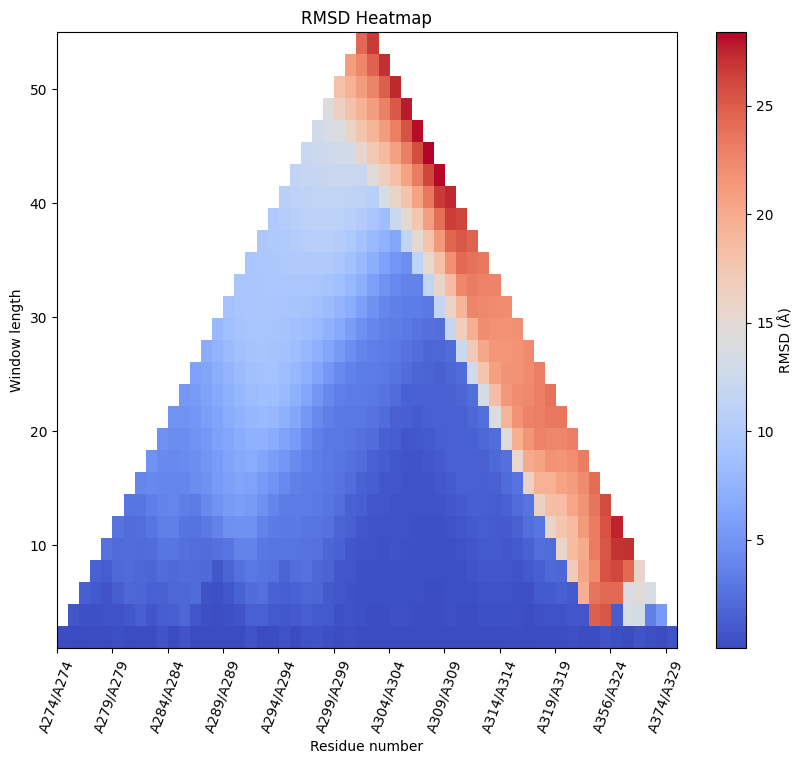

7.334320326715402


: 

In [ ]:
coords1, coords2, chid1, chid2, resnums1, resnums2, \
    phis1, psis1, phis2, psis2 = extract_corresponding_coords(pdb1, pdb2, True)
mean_rmsd = plot_window_rmsds_3d(coords1, coords2, chid1, chid2, resnums1, resnums2)
print(mean_rmsd)

Text(0, 0.5, 'Cosine difference')

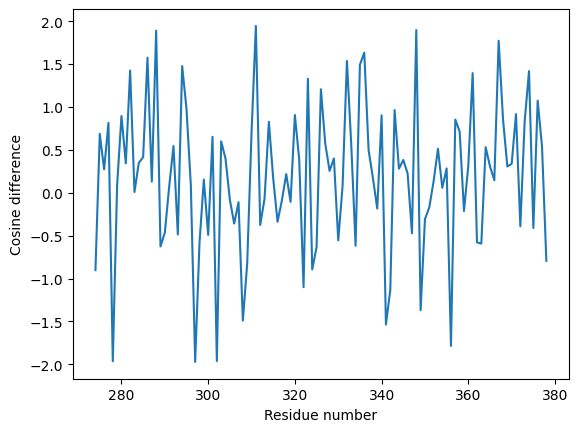

In [311]:
mask = np.logical_and(
    np.logical_and(np.logical_not(np.isnan(phis1)), 
                   np.logical_not(np.isnan(phis2))),
    np.logical_and(np.logical_not(np.isnan(psis1)), 
                   np.logical_not(np.isnan(psis2))),
)
cosines = phi_psi_cosine_difference(phis1[mask], psis1[mask], 
                                    phis2[mask], psis2[mask])
idxs = resnums1[mask]
plt.plot(idxs, cosines)
plt.xlabel('Residue number')
plt.ylabel('Cosine difference')